In [1]:
pip install pandas scikit-learn imblearn matplotlib

Note: you may need to restart the kernel to use updated packages.


In [8]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    average_precision_score, precision_recall_curve
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


In [9]:
# Path to your file
FOLDER = r"C:\Users\USER\Documents\SEM 6\ML\Task 2"
FILE = "data"   # works for data.xlsx or data.csv

df = None
for ext in [".xlsx", ".csv"]:
    path = os.path.join(FOLDER, FILE + ext)
    if os.path.exists(path):
        df = pd.read_excel(path) if ext == ".xlsx" else pd.read_csv(path)
        print("Loaded:", path)
        break

assert df is not None, "File not found"

df.head()


Loaded: C:\Users\USER\Documents\SEM 6\ML\Task 2\data.csv


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Shape: (7043, 21)

Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Missing Values:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Duplicate rows: 0

Sample Churn distribution:
Churn
No     5174
Yes    1869
Name: count, dtype: int64
Churn
No     0.735
Yes    0.265
Name: proportion, dty

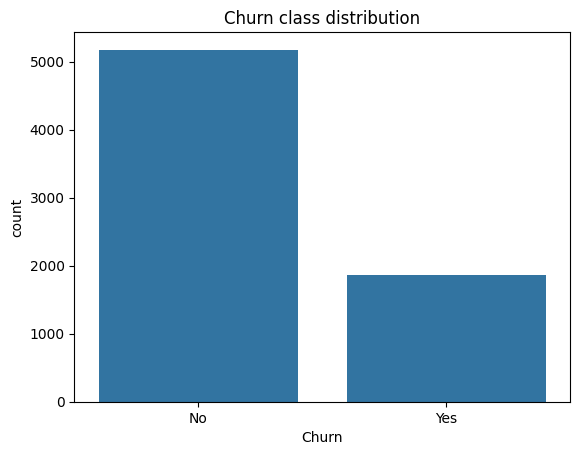

In [10]:
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nDuplicate rows:", df.duplicated().sum())

print("\nSample Churn distribution:")
print(df['Churn'].value_counts())
print(df['Churn'].value_counts(normalize=True).round(3))

sns.countplot(x='Churn', data=df)
plt.title("Churn class distribution")
plt.show()


In [11]:
# Drop ID
if 'customerID' in df.columns:
    df = df.drop(columns=['customerID'])

# Convert target to numbers
df['target'] = df['Churn'].map({'Yes':1, 'No':0})

# Fix numeric column with blanks
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Remove duplicates (if any)
df = df.drop_duplicates()

# Report missing again
print(df.isnull().sum())


gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
target               0
dtype: int64


In [12]:
# Example engineered feature: MonthlyCharges * tenure (estimate total cost)
if 'tenure' in df.columns and 'MonthlyCharges' in df.columns:
    df['EstLifetimeSpend'] = df['tenure'] * df['MonthlyCharges']

df.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,target,EstLifetimeSpend
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0,29.85
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,No,One year,No,Mailed check,56.95,1889.50,No,0,1936.30
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,107.70
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0,1903.50
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,141.40


In [13]:
X = df.drop(columns=['Churn','target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Positive rate in train:", round(y_train.mean()*100, 2), "%")


Train: (5616, 20) Test: (1405, 20)
Positive rate in train: 26.44 %


In [16]:
num_cols = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=['int64','float64']).columns.tolist()

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
except:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=True)

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', ohe)
])

preprocess = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])


In [17]:
log_reg = LogisticRegression(max_iter=2000, class_weight='balanced')
rf = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1, class_weight='balanced_subsample')

pipe_lr = Pipeline([('pre', preprocess), ('clf', log_reg)])
pipe_rf = Pipeline([('pre', preprocess), ('clf', rf)])

# Manual undersampling function
def undersample(X, y):
    data = X.copy()
    data['_y_'] = y.values
    minority = data[data['_y_']==1]
    majority = data[data['_y_']==0]
    down = majority.sample(len(minority), random_state=42)
    balanced = pd.concat([minority, down]).sample(frac=1, random_state=42)
    return balanced.drop(columns=['_y_']), balanced['_y_']

X_train_bal, y_train_bal = undersample(X_train, y_train)
print("Balanced training size:", X_train_bal.shape)
print("Balanced pos%:", round(y_train_bal.mean()*100, 2), "%")


Balanced training size: (2970, 20)
Balanced pos%: 50.0 %


In [18]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cv_score(pipe):
    return cross_val_score(pipe, X_train, y_train, cv=cv,
                           scoring='average_precision', n_jobs=-1).mean()

print("CV PR-AUC Logistic Regression:", round(cv_score(pipe_lr),4))
print("CV PR-AUC Random Forest:", round(cv_score(pipe_rf),4))


CV PR-AUC Logistic Regression: 0.6559
CV PR-AUC Random Forest: 0.6202


In [19]:
def evaluate(name, pipe, Xtr, ytr):
    pipe.fit(Xtr, ytr)
    proba = pipe.predict_proba(X_test)[:,1]
    preds = (proba >= 0.5).astype(int)
    
    print(f"\n=== {name} @ 0.5 Threshold ===")
    print("ROC-AUC:", round(roc_auc_score(y_test, proba), 4))
    print("PR-AUC :", round(average_precision_score(y_test, proba), 4))
    print(classification_report(y_test, preds))
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))
    return proba

proba_lr = evaluate("Logistic Regression", pipe_lr, X_train_bal, y_train_bal)
proba_rf = evaluate("Random Forest", pipe_rf, X_train_bal, y_train_bal)



=== Logistic Regression @ 0.5 Threshold ===
ROC-AUC: 0.8406
PR-AUC : 0.6368
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1033
           1       0.51      0.78      0.62       372

    accuracy                           0.75      1405
   macro avg       0.71      0.76      0.71      1405
weighted avg       0.80      0.75      0.76      1405

Confusion Matrix:
 [[757 276]
 [ 82 290]]

=== Random Forest @ 0.5 Threshold ===
ROC-AUC: 0.826
PR-AUC : 0.6338
              precision    recall  f1-score   support

           0       0.89      0.75      0.81      1033
           1       0.51      0.73      0.60       372

    accuracy                           0.75      1405
   macro avg       0.70      0.74      0.71      1405
weighted avg       0.79      0.75      0.76      1405

Confusion Matrix:
 [[774 259]
 [ 99 273]]


In [21]:
def best_threshold(y_true, y_score):
    p, r, t = precision_recall_curve(y_true, y_score)
    f1 = (2*p*r)/(p+r+1e-12)
    idx = np.argmax(f1)
    return t[max(idx-1,0)], f1[idx]

for name, proba in [("LR", proba_lr), ("RF", proba_rf)]:
    thr, f1 = best_threshold(y_test, proba)
    preds = (proba >= thr).astype(int)
    print(f"\n=== {name} Tuned Threshold {thr:.3f} (F1={f1:.4f}) ===")
    print(classification_report(y_test, preds))
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))



=== LR Tuned Threshold 0.521 (F1=0.6228) ===
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1033
           1       0.52      0.76      0.62       372

    accuracy                           0.75      1405
   macro avg       0.71      0.76      0.72      1405
weighted avg       0.80      0.75      0.77      1405

Confusion Matrix:
 [[776 257]
 [ 88 284]]

=== RF Tuned Threshold 0.535 (F1=0.6084) ===
              precision    recall  f1-score   support

           0       0.88      0.78      0.83      1033
           1       0.53      0.70      0.61       372

    accuracy                           0.76      1405
   macro avg       0.71      0.74      0.72      1405
weighted avg       0.79      0.76      0.77      1405

Confusion Matrix:
 [[804 229]
 [111 261]]


In [22]:
param_lr = {
    'clf__C': np.logspace(-3, 3, 20),
    'clf__solver': ['lbfgs', 'liblinear']
}

param_rf = {
    'clf__n_estimators': [300, 400, 600, 800],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__max_features': ['sqrt', 'log2']
}

def tune(pipe, params, name):
    search = RandomizedSearchCV(pipe, params, n_iter=20, cv=cv,
                                scoring='average_precision', n_jobs=-1)
    search.fit(X_train_bal, y_train_bal)
    proba = search.predict_proba(X_test)[:,1]
    print(f"\nBest {name} CV PR-AUC:", round(search.best_score_,4))
    print("Best Params:", search.best_params_)
    print("Test ROC-AUC:", round(roc_auc_score(y_test, proba),4))
    print("Test PR-AUC :", round(average_precision_score(y_test, proba),4))
    return search

best_lr = tune(pipe_lr, param_lr, "Logistic Regression")
best_rf = tune(pipe_rf, param_rf, "Random Forest")



Best Logistic Regression CV PR-AUC: 0.8347
Best Params: {'clf__solver': 'liblinear', 'clf__C': 0.3359818286283781}
Test ROC-AUC: 0.8404
Test PR-AUC : 0.6364

Best Random Forest CV PR-AUC: 0.8399
Best Params: {'clf__n_estimators': 600, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 4, 'clf__max_features': 'sqrt', 'clf__max_depth': 10}
Test ROC-AUC: 0.8416
Test PR-AUC : 0.6529


In [23]:
# Top 20 features from Random Forest
ohe = best_rf.best_estimator_.named_steps['pre'].named_transformers_['cat'].named_steps['ohe']
cat_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_cols, cat_names])

importance = best_rf.best_estimator_.named_steps['clf'].feature_importances_
imp_series = pd.Series(importance, index=feature_names).sort_values(ascending=False).head(20)
print("\nTop 20 important features:\n", imp_series)



Top 20 important features:
 Contract_Month-to-month                0.110347
tenure                                 0.109368
TotalCharges                           0.087167
EstLifetimeSpend                       0.082357
MonthlyCharges                         0.065042
OnlineSecurity_No                      0.057568
Contract_Two year                      0.056498
InternetService_Fiber optic            0.047313
TechSupport_No                         0.043100
PaymentMethod_Electronic check         0.032164
InternetService_DSL                    0.020364
OnlineBackup_No                        0.017942
Contract_One year                      0.017280
DeviceProtection_No                    0.013929
OnlineSecurity_Yes                     0.011870
StreamingMovies_No internet service    0.011810
OnlineSecurity_No internet service     0.011392
TechSupport_Yes                        0.010942
PaperlessBilling_No                    0.010938
PaperlessBilling_Yes                   0.010458
dtype: floa